# Demo de Modelos de Markov para realizar predeciones de estados con series temporales
Se basa en clases de https://github.com/maximtrp/mchmm/tree/master/mchmm para Modelos de Markov

In [ ]:
#@title Librerías a usar

from IPython.display import Image, display

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

# función auxiliar para graficar datos
def graficarSerieDatos(datosReal, datosModelo=None, titulo=""):
  if (datosReal is None) and (datosModelo is None):
    return
  legNames = []
  plt.figure(figsize=(15,8))
  if datosReal is not None:
    plt.plot(datosReal)
    legNames.append( "Real" )
  if datosModelo is not None:
    plt.plot(datosModelo)
    legNames.append( "Modelo" )
  if titulo != "":
    plt.title(titulo)

  plt.ylabel('valor Y')
  plt.xlabel('# ejemplo')
  if len(legNames) > 1:
    plt.legend(legNames, loc='upper left')
  plt.show()


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA_nuevo.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

#@markdown -Nota: se considera que los ejemplos formas una serie temporal.
## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Xori, Yori, nombre_clases, atributo_clase, atributo_entrada

  if (attClase is None) or (attClase ==""):
    return

  # guarda configuración
  nombre_clases = nomClases

  # genera los datos solo con los atributos seleccionados
  Yori = np.array(df[attClase])
  if (att_entrada == "") or (att_entrada == "-") or (att_entrada == attClase):
    print("\n> No se utiliza atributo entrada")
    Xori = None
    atributo_entrada = ""
  else:
    atributo_entrada = att_entrada
    Xori = np.array(df[att_entrada])
    print("\n> Atributo entrada: ", att_entrada)
    print("\t X: ", Xori.shape)

  # muestra resultados
  atributo_clase = attClase
  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Yori.shape)


## selección de los parámetros

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")


def mostrarDatosEjemplos(df):
  print("\n Cabecera: ")
  print(df.head())
  print("\n Características: ")
  print(df.describe())
  print("\n")

mostrarDatosEjemplos(df)
print(" -Nota: se considera que los ejemplos formas una serie temporal. \n")
Xori = None
Yori = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

selecc_atributos.append("-")
att_selecc_defecto = len(selecc_atributos)-1
combo_att_entrada = widgets.Dropdown(
    options=selecc_atributos,
    value=selecc_atributos[att_selecc_defecto],
    description='Atributo de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  CLIMA_nuevo.csv  cargado

 Cabecera: 
   fecha_dia  fecha_mes  temp_prom  temp_min  tem_max  viento_dir  viento_vel  \
0          1          1       24.8      20.6     34.6          15        14.8   
1          2          1       26.4      16.7     35.0         354        10.6   
2          3          1       29.2      21.0     37.2          75        11.2   
3          4          1       28.1      20.7     37.6         231        15.6   
4          5          1       20.6      10.5     31.1         130        16.1   

   presion  precipitacion  
0   1003.6            0.0  
1   1004.6            0.0  
2   1006.7            0.0  
3   1005.9            0.0  
4   1015.4            0.0  

 Características: 
        fecha_dia   fecha_mes   temp_prom    temp_min     tem_max  viento_dir  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean    15.720548    6.526027   17.733836   11.902466   24.531233  151.952055   
std      8.802278    3.450

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…



> No se utiliza atributo entrada

> Atributo clase:  precipitacion
	 Y:  (730,)


> No se utiliza atributo entrada

> Atributo clase:  temp_prom
	 Y:  (730,)


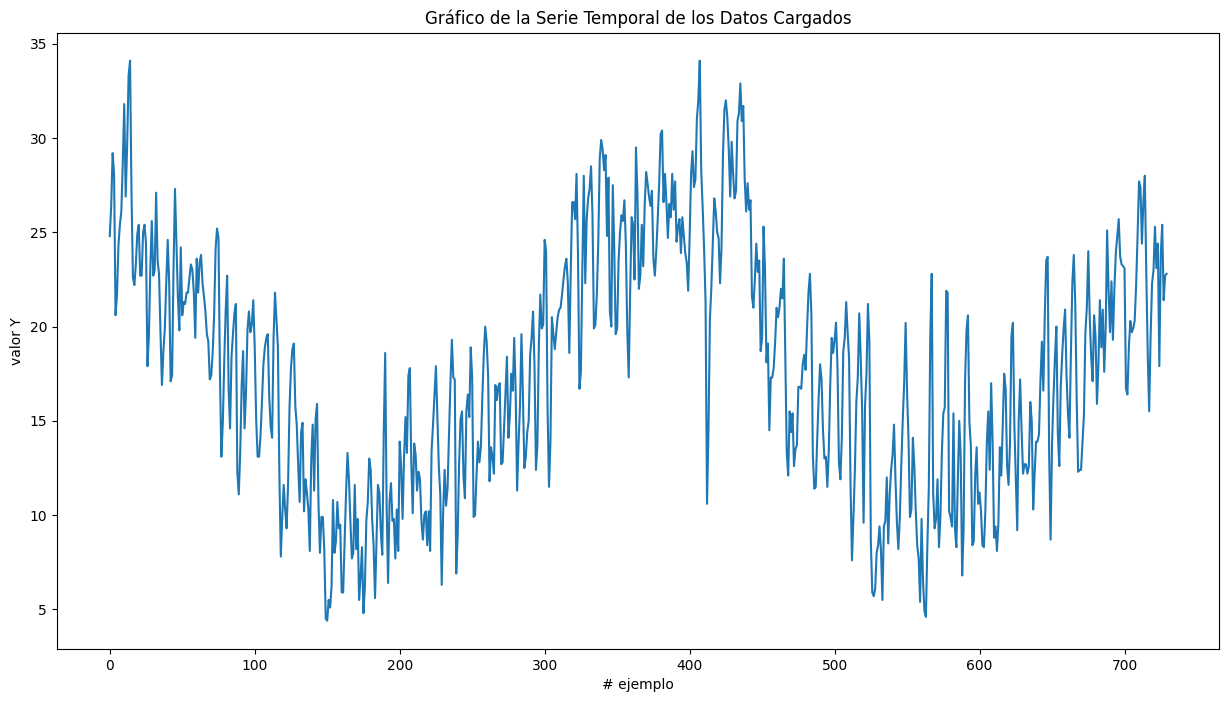

In [ ]:
#@title Mostrar Gráfico de los datos cargados

graficarSerieDatos(datosReal=Yori,
                   titulo="Gráfico de la Serie Temporal de los Datos Cargados")

In [ ]:
#@title Preparar datos - Discretizar

#@markdown Para atributo clase:
att_clase_preparacion_discretizacion = "-" #@param ["Asignar nombre clases", "Variacion % con anterior", "-"]
att_clase_tipo_discretizacion =  "Rangos Misma Cantidad - Quantile" #@param ["Rangos usando Decenas", "Rangos Mismo Ancho - Uniform", "Rangos Misma Cantidad - Quantile", "Rangos Clustered"]
att_clase_cant_rangos_discretizacion = 3 #@param {type:"integer"}

#@markdown Para atributo de entrada:
att_entrada_tipo_discretizacion = "Rangos Misma Cantidad - Quantile" #@param ["Rangos usando Decenas", "Rangos Mismo Ancho - Uniform", "Rangos Misma Cantidad - Quantile", "Rangos Clustered"]
att_entrada_cant_rangos_discretizacion = 4 #@param {type:"integer"}

from sklearn.preprocessing import KBinsDiscretizer

# hace una copia para trabajar
X = None
Y = None
clases_map = None

def crearDatosEjemplos(Xar, Yar):
  if Xar is None:
    return pd.DataFrame({"Y":Yar})
  else:
    return pd.DataFrame({"X":Xar, "Y":Yar})

def discretizarDatosKbins(datos, kbins, prefijo="rango"):
    res = kbins.fit_transform( datos.reshape(-1, 1) )
    if prefijo != "":
      prefijo = prefijo + "_"
    res = [ prefijo + "r" + ("00"+str( int(v[0]+1 )))[-2:] for v in res ]
    return np.array(res)


def discretizarDatosx10(datos, prefijo="rango"):
    if prefijo != "":
      prefijo = prefijo + "_"
    res = [ prefijo + "d" + str( int(v//10) ) + "x" for v in datos ]
    return np.array(res)


def calculoVariacionDatos(datos, valorMaximo=999.999):
    res = []
    for i in range(0, len(datos)):
        if i == 0:
          # es el primero, no hay anterior
          var = 100.00
        else:
          # el resto
          valAnt = datos[i-1]
          valAct = datos[i]
          if valAnt == 0:
            # asigna máximo
            # porque no puede dividir por cero
            var = valorMaximo
          else:
            var = valAct*100.0 / valAnt
            if var > valorMaximo:
              # si supera máximo, usa ese valor
              var = valorMaximo
        res.append( var )
    #if prefijo != "":
    #  prefijo = prefijo + "_"
    #res = [ prefijo + "%" + str(int(v))  for v in res ]
    #res = discretizarDatosx10(res, prefijo+"_%")
    return np.array(res)

# función auxiliar para graficar
def sacarDiscreatizacionDatos(datos):
  res = []
  for v in datos:
    if v == "NA":
      # usa como está
      res.append( -1 )
    else:
      # saca lo de adelante
      pos = v.rfind('_')
      if pos < 0:
        pos = -1
      v = v[pos+2:]
      if "x" in v:
        v = v.replace("x", "0")
      res.append( int(v) )
  return np.array( res )


def prepararDatosModMarkov_X(Xori, atributo_entrada, att_entrada_tipo_discretizacion, att_entrada_cant_rangos_discretizacion):
  X = None
  if not(Xori is None):
    if att_entrada_tipo_discretizacion ==  "Rangos usando Decenas":
        # determina rangos tomando hasta decenas (descarta unidades y decimales)
        print("-- Se discretiza descartando unidades y decimales al atributo entrada:", atributo_entrada)
        X = discretizarDatosx10(Xori, atributo_entrada)
    else:
        if att_entrada_cant_rangos_discretizacion < 2:
          att_entrada_cant_rangos_discretizacion = 2

        # elegir el método de normalización
        if att_entrada_tipo_discretizacion == "Rangos Mismo Ancho - Uniform":
          ent_kbins = KBinsDiscretizer(n_bins=att_entrada_cant_rangos_discretizacion, encode='ordinal', strategy='uniform')
        elif att_entrada_tipo_discretizacion == "Rangos Misma Cantidad - Quantile":
          ent_kbins = KBinsDiscretizer(n_bins=att_entrada_cant_rangos_discretizacion, encode='ordinal', strategy='quantile')
        elif att_entrada_tipo_discretizacion == "Rangos Clustered":
          ent_kbins = KBinsDiscretizer(n_bins=att_entrada_cant_rangos_discretizacion, encode='ordinal', strategy='kmeans')

        # el atributo entrdada  genera rango y le asigna nombre genérico
        print("-- Se discretiza con ", att_entrada_cant_rangos_discretizacion," rangos al atributo entrada:", atributo_entrada)
        X = discretizarDatosKbins(Xori, ent_kbins, atributo_entrada)
  # devuelve resultados
  return X

def prepararDatosModMarkov_Y(Yori, atributo_clase, nombre_clases, att_clase_preparacion_discretizacion, att_clase_tipo_discretizacion, att_clase_cant_rangos_discretizacion):
  Y = None
  clases_map = None
  # aplica la normalización sólo en columnas de datos
  if not(Yori is None):
    # preparación
    if att_clase_preparacion_discretizacion == "Asignar nombre clases":
      # preparación asignando nombre clases
      # nota: luego no es necesario determinar rangos
      if nombre_clases == "":
        raise Exception("No se ha definido nombre clases en la celda anterior!")
      else:
        clases_map = nombre_clases.split(",")
        # el atributo clase y se conocen los nombres los usa
        print("-- Se asigna nombres a atributo clase:", )
        Y = np.array([ clases_map[v] for v in Yori ])
    else:

      if att_clase_preparacion_discretizacion ==  "Variacion % con anterior":
          # preparación calculando variación con respecto al valor anterior
          print("-- Se prepara calculando variación de valores al atributo clase:", atributo_clase)
          Y = calculoVariacionDatos(Yori)
          prefijo = atributo_clase + "_%"
      else:
          # si no se prepara
          Y = Yori
          prefijo = atributo_clase
      # aplica rangos para discretización
      if att_clase_tipo_discretizacion ==  "Rangos usando Decenas":
          # determina rangos tomando hasta decenas (descarta unidades y decimales)
          print("-- Se discretiza descartando unidades y decimales al atributo clase:", atributo_clase)
          Y = discretizarDatosx10(Y, prefijo)
      else:
          # discretización por rangos
          if att_clase_cant_rangos_discretizacion < 2:
            att_clase_cant_rangos_discretizacion = 2

          # elegir el método de normalización
          if att_clase_tipo_discretizacion == "Rangos Mismo Ancho - Uniform":
            cl_kbins = KBinsDiscretizer(n_bins=att_clase_cant_rangos_discretizacion, encode='ordinal', strategy='uniform')
          elif att_clase_tipo_discretizacion == "Rangos Misma Cantidad - Quantile":
            cl_kbins = KBinsDiscretizer(n_bins=att_clase_cant_rangos_discretizacion, encode='ordinal', strategy='quantile')
          elif att_clase_tipo_discretizacion == "Rangos Clustered":
            cl_kbins = KBinsDiscretizer(n_bins=att_clase_cant_rangos_discretizacion, encode='ordinal', strategy='kmeans')

          print("-- Se discretiza con ", att_clase_cant_rangos_discretizacion," rangos al atributo clase:", atributo_clase)
          Y = discretizarDatosKbins(Y, cl_kbins, prefijo)
  # devuelve resultado
  return Y, clases_map


print("> Datos antes a discretizar: ")
mostrarDatosEjemplos( crearDatosEjemplos(Xori, Yori) )

X = prepararDatosModMarkov_X(Xori, atributo_entrada, att_entrada_tipo_discretizacion, att_entrada_cant_rangos_discretizacion)
Y, clases_map = prepararDatosModMarkov_Y(Yori, atributo_clase, nombre_clases, att_clase_preparacion_discretizacion, att_clase_tipo_discretizacion, att_clase_cant_rangos_discretizacion)

print("\n> Datos luego de discretizar: ")
mostrarDatosEjemplos( crearDatosEjemplos(X, Y) )

> Datos antes a discretizar: 

 Cabecera: 
      Y
0  24.8
1  26.4
2  29.2
3  28.1
4  20.6

 Características: 
                Y
count  730.000000
mean    17.733836
std      6.395932
min      4.400000
25%     12.600000
50%     17.750000
75%     22.700000
max     34.100000


-- Se discretiza con  3  rangos al atributo clase: temp_prom

> Datos luego de discretizar: 

 Cabecera: 
               Y
0  temp_prom_r03
1  temp_prom_r03
2  temp_prom_r03
3  temp_prom_r03
4  temp_prom_r02

 Características: 
                    Y
count             730
unique              3
top     temp_prom_r02
freq              245




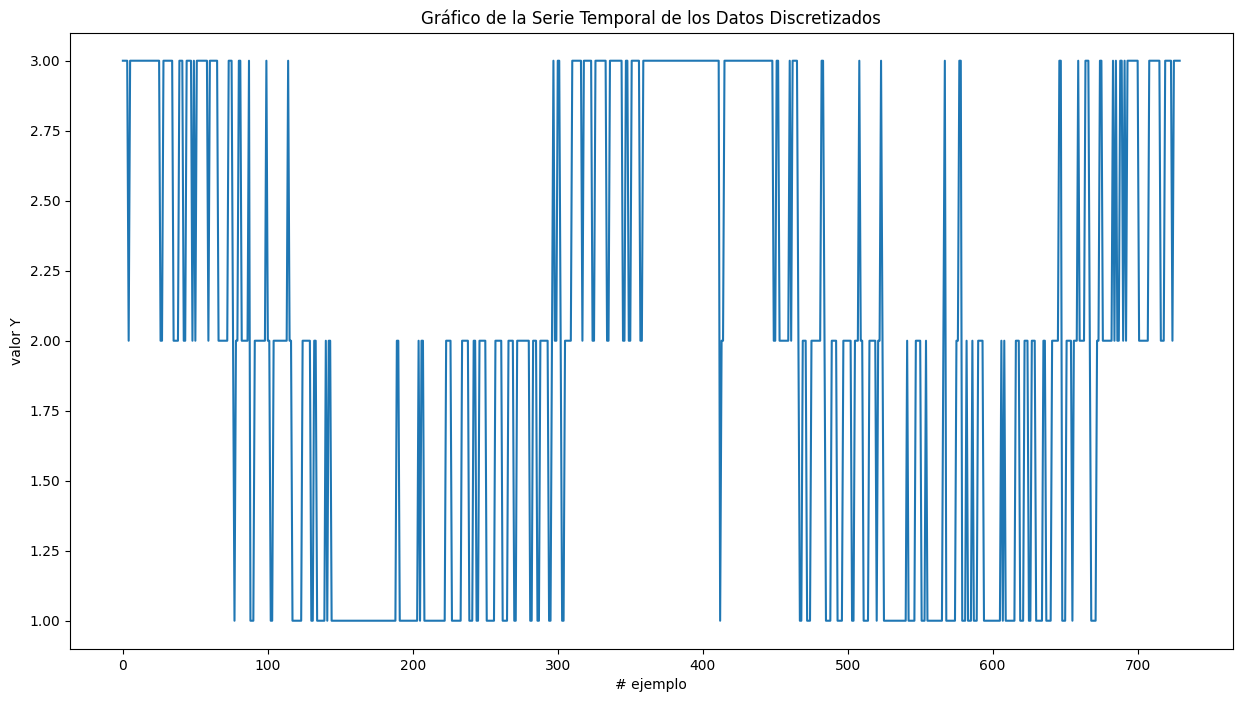

In [ ]:
#@title Mostrar Gráfico de los datos discretizados
graficarSerieDatos(datosReal=sacarDiscreatizacionDatos(Y),
                   titulo="Gráfico de la Serie Temporal de los Datos Discretizados")

In [ ]:
#@title Preparar datos - Separar Entrenamiento / Prueba

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento = 80 #@param {type:"integer"}
#@markdown Nota: como se considera que los ejemplos forman una serie temporal, toma los primeros para entrenar y el resto para probsar (no puede tomar al azar porque rompería la serie).

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100
cantEjemplosTrain = int(len(Y) * propTrain)
if cantEjemplosTrain < 1:
  cantEjemplosTrain = 1

# separa al azar tomando los primeros como de entrenamiento y el resto de prueba
# nota: no se puede hacer muestreo al azar porque se considera que los ejemplos forman serie temporal
if X is None:
  x_train = None
  y_train = Y[0:cantEjemplosTrain]
  x_test = None
  y_test = Y[cantEjemplosTrain:]
else:
  x_train = X[0:cantEjemplosTrain]
  y_train = Y[0:cantEjemplosTrain]
  x_test = X[cantEjemplosTrain:]
  y_test = Y[cantEjemplosTrain:]

print("\n> Para Entrenamiento: ")
print(" - x_train (cant): ", ("-" if x_train is None else x_train.shape))
print(" - y_train (cant): ", len(y_train))

print("\n Para Prueba: ")
print(" - x_test (cant): ", ("-" if x_test is None else x_test.shape))
print(" - y_test (cant): ", len(y_test))



> Para Entrenamiento: 
 - x_train (cant):  -
 - y_train (cant):  584

 Para Prueba: 
 - x_test (cant):  -
 - y_test (cant):  146


# Modelo:

In [ ]:
#@title Define clases para Modelos de Markov
#@markdown Basado en https://github.com/maximtrp/mchmm/tree/master/mchmm con algunas correcciones y mejoras

import operator
import numpy as np
import scipy.stats as ss
from itertools import product
from graphviz import Digraph
from typing import Union, Tuple, Optional
import numpy.linalg as nl
import scipy.stats as ss

class MarkovChain:

    def __init__(
            self,
            states: Optional[Union[np.ndarray, list]] = None,
            obs: Optional[Union[np.ndarray, list]] = None,
            obs_p: Optional[Union[np.ndarray, list]] = None):
        '''Discrete Markov Chain.
        Parameters
        ----------
        states : Optional[Union[numpy.ndarray, list]
            State names list.
        obs : Optional[Union[numpy.ndarray, list]
            Observed transition frequency matrix.
        obs_p : Optional[Union[numpy.ndarray, list]
            Observed transition probability matrix.
        '''

        self.states = np.array(states)
        self.observed_matrix = np.array(obs)
        self.observed_p_matrix = np.array(obs_p)

    def _transition_matrix(
            self,
            seq: Optional[Union[str, list, np.ndarray]] = None,
            states: Optional[Union[str, list, np.ndarray]] = None
            ) -> np.ndarray:
        '''Calculate a transition frequency matrix.
        Parameters
        ----------
        seq : Optional[Union[str, list, numpy.ndarray]]
            Observations sequence.
        states : Optional[Union[str, list, numpy.ndarray]]
            List of states.
        Returns
        -------
        matrix : numpy.ndarray
            Transition frequency matrix.
        '''

        seql = self.seq if seq is None else np.array(list(seq))
        states = self.states if states is None else np.array(list(states))
        matrix = np.zeros((len(states), len(states)))

        for x, y in product(range(len(states)), repeat=2):
            xid = np.argwhere(seql == states[x]).flatten()
            yid = xid + 1
            yid = yid[yid < len(seql)]
            s = np.count_nonzero(seql[yid] == states[y])
            matrix[x, y] = s

        return matrix

    def n_order_matrix(
            self,
            mat: np.ndarray = None,
            order: int = 2) -> np.ndarray:
        '''Create Nth order transition probability matrix.
        Parameters
        ----------
        mat : numpy.ndarray, optional
            Observed transition probability matrix.
        order : int, optional
            Order of transition probability matrix to return.
            Default is 2.
        Returns
        -------
        x : numpy.ndarray
            Nth order transition probability matrix.
        '''

        return nl.matrix_power(
            self.observed_p_matrix if mat is None else mat,
            order
        )

    def prob_to_freq_matrix(
            self,
            mat: np.ndarray = None,
            row_totals: np.ndarray = None) -> np.ndarray:
        '''Calculate a transition frequency matrix given a transition
        probability matrix and row totals. This method is meant to be
        used to calculate a frequency matrix for a Nth order
        transition probability matrix.
        Parameters
        ----------
        mat : numpy.ndarray, optional
            Transition probability matrix.
        row_totals : numpy.ndarray, optional
            Row totals of transition frequency matrix.
        Returns
        -------
        x : numpy.ndarray
            Transition frequency matrix.
        '''

        _mat = self.observed_p_matrix if mat is None else mat
        _rt = self._obs_row_totals if row_totals is None else row_totals
        _rt = _rt[:, None] if _rt.ndim == 1 else _rt
        return _mat * _rt

    def from_data(
            self,
            seq: Union[str, np.ndarray, list]) -> object:
        '''Infer a Markov chain from data. States, frequency and probability
        matrices are automatically calculated and assigned to as class
        attributes.
        Parameters
        ----------
        seq : Union[str, np.ndarray, list]
            Sequence of events. A string or an array-like object exposing the
            array interface and containing strings or ints.
        Returns
        -------
        MarkovChain : object
            Trained MarkovChain class instance.
        '''
        # states list
        self.seq = np.array(list(seq))
        self.states = np.unique(list(seq))

        # observed transition frequency matrix
        self.observed_matrix = self._transition_matrix(seq)
        self._obs_row_totals = np.sum(self.observed_matrix, axis=1)

        # observed transition probability matrix
        self.observed_p_matrix = np.nan_to_num(
            self.observed_matrix / self._obs_row_totals[:, None]
        )

        # filling in a row containing zeros with uniform p values
        uniform_p = 1 / len(self.states)
        zero_row = np.argwhere(self.observed_p_matrix.sum(1) == 0).ravel()
        self.observed_p_matrix[zero_row, :] = uniform_p

        # expected transition frequency matrix
        self.expected_matrix = ss.contingency.expected_freq(
            self.observed_matrix)

        return self

    def chisquare(
            self,
            obs: np.ndarray = None,
            exp: np.ndarray = None,
            **kwargs
            ) -> Tuple[Union[float, np.ndarray], Union[float, np.ndarray]]:
        '''Wrapper function for carrying out a chi-squared test using
        `scipy.stats.chisquare` method.
        Parameters
        ----------
        obs : numpy.ndarray
            Observed transition frequency matrix.
        exp : numpy.ndarray
            Expected transition frequency matrix.
        kwargs : optional
            Keyword arguments passed to `scipy.stats.chisquare` method.
        Returns
        -------
        chisq : float or numpy.ndarray
            Chi-squared test statistic.
        p : float or numpy.ndarray
            P value of the test.
        '''

        _obs = self.observed_matrix if obs is None else obs
        _exp = self.expected_matrix if exp is None else exp
        return ss.chisquare(f_obs=_obs, f_exp=_exp, **kwargs)

    def graph_make(self, *args, **kwargs) -> Digraph:
        '''Make a directed graph of a Markov chain using `graphviz`.
        Parameters
        ----------
        args : optional
            Arguments passed to the underlying `graphviz.Digraph` method.
        kwargs : optional
            Keyword arguments passed to the underlying `graphviz.Digraph`
            method.
        Returns
        -------
        graph : graphviz.dot.Digraph
            Digraph object with its own methods.
        Note
        ----
        `graphviz.dot.Digraph.render` method should be used to output a file.
        '''
        self.graph = Digraph(*args, **kwargs)

        ids = range(len(self.states))
        edges = product(ids, ids)

        for edge in edges:
            v1 = edge[0]
            v2 = edge[1]
            s1 = self.states[v1]
            s2 = self.states[v2]
            p = str(np.round(self.observed_p_matrix[v1, v2], 2))
            self.graph.edge(s1, s2, label=p, weight=p)

        return self.graph

    def simulate(
            self,
            n: int,
            tf: np.ndarray = None,
            states: Optional[Union[np.ndarray, list]] = None,
            start: Optional[Union[str, int]] = None,
            ret: str = 'both',
            seed: Optional[Union[list, np.ndarray]] = None
            ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        '''Markov chain simulation based on `scipy.stats.multinomial`.
        Parameters
        ----------
        n : int
            Number of states to simulate.
        tf : numpy.ndarray, optional
            Transition frequency matrix.
            If None, `observed_matrix` instance attribute is used.
        states : Optional[Union[np.ndarray, list]]
            State names. If None, `states` instance attribute is used.
        start : Optional[str, int]
            Event to begin with.
            If integer is passed, the state is chosen by index.
            If string is passed, the state is chosen by name.
            If `random` string is passed, a random state is taken.
            If left unspecified (None), an event with maximum
            probability is chosen.
        ret : str, optional
            Return state indices if `indices` is passed.
            If `states` is passed, return state names.
            Return both if `both` is passed.
        seed : Optional[Union[list, numpy.ndarray]]
            Random states used to draw random variates (of size `n`).
            Passed to `scipy.stats.multinomial` method.
        Returns
        -------
        x : numpy.ndarray
            Sequence of state indices.
        y : numpy.ndarray, optional
            Sequence of state names.
            Returned if `return` arg is set to 'states' or 'both'.
        '''
        # matrices init
        if tf is None:
            tf = self.observed_matrix
            fp = self.observed_p_matrix
        else:
            fp = tf / tf.sum(axis=1)[:, None]

        # states init
        if states is None:
            states = self.states
        if not isinstance(states, np.ndarray):
            states = np.array(states)

        # choose a state to begin with
        # `_start` is always an index of state
        if start is None:
            row_totals = tf.sum(axis=1)
            _start = np.argmax(row_totals / tf.sum())
        elif isinstance(start, int):
            _start = start if start < len(states) else len(states)-1
        elif start == 'random':
            _start = np.random.randint(0, len(states))
        elif isinstance(start, str):
            if start not in states:
              # si no la encuentra asigna ultimo valor
              print("--No se encuentra estado inicial ", start, "en ", states)
              return [-1], ["NA"]
            _start = np.argwhere(states == start).item()

        # simulated sequence init
        seq = np.zeros(n, dtype=int)
        seq[0] = _start

        # random seeds
        r_states = np.random.randint(0, n, n) if seed is None else seed

        # simulation procedure
        for i in range(1, n):
            _ps = fp[seq[i-1]]
            _sample = np.argmax(
                ss.multinomial.rvs(1, _ps, 1, random_state=r_states[i])
            )
            seq[i] = _sample

        if ret == 'indices':
            return seq
        elif ret == 'states':
            return states[seq]
        else:
            return seq, states[seq]


class HiddenMarkovModel:

    def __init__(
            self,
            observations: Optional[Union[list, np.ndarray]] = None,
            states: Optional[Union[list, np.ndarray]] = None,
            tp: Optional[Union[list, np.ndarray]] = None,
            ep: Optional[Union[list, np.ndarray]] = None,
            pi: Optional[Union[list, np.ndarray]] = None):
        '''Hidden Markov model.
        Parameters
        ----------
        observations : Optional[Union[list, np.ndarray]]
            Observations space (of size N).
        states : Optional[Union[list, np.ndarray]]
            List of states (of size K).
        tp : Optional[Union[list, np.ndarray]]
            Transition matrix of size K × K which stores transition
            probability of transiting from state i (row) to state j (col).
        ep : Optional[Union[list, np.ndarray]]
            Emission matrix of size K × N which stores probability of
            seeing observation j (col) from state i (row). N is the length of
            observation space O = [o_1, o_2, ..., o_N].
        pi : Optional[Union[list, np.ndarray]]
            Initial state probabilities array (of size K).
        '''

        self.observations = np.array(observations)
        self.states = np.array(states)
        self.tp = np.array(tp)
        self.ep = np.array(ep)
        self.pi = np.array(pi)

    def _transition_matrix(
            self,
            seq: Optional[Union[str, np.ndarray, list]] = None,
            states: Optional[Union[str, np.ndarray, list]] = None):
        '''Calculate a transition probability matrix which stores transition
        probability of transiting from state i to state j.
        Parameters
        ----------
        seq : Optional[Union[str, numpy.ndarray, list]]
            Sequence of states.
        states : Optional[Union[str, numpy.ndarray, list]]
            List of unique states.
        Returns
        -------
        matrix : numpy.ndarray
            Transition frequency matrix.
        '''
        seql = self.states_seq if seq is None else np.array(list(seq))
        if states is None:
            states = self.states
        T = len(seql)
        K = len(states)

        matrix = np.zeros((K, K))

        for x, y in product(range(K), repeat=2):
            xid = np.argwhere(seql == states[x]).flatten()
            yid = xid + 1
            yid = yid[yid < T]
            s = np.count_nonzero(seql[yid] == states[y])
            matrix[x, y] = s

        matrix /= matrix.sum(axis=1)[:, None]
        return matrix

    def _emission_matrix(
            self,
            obs_seq: Optional[Union[str, list, np.ndarray]] = None,
            states_seq: Optional[Union[str, list, np.ndarray]] = None,
            obs: Optional[Union[str, list, np.ndarray]] = None,
            states: Optional[Union[str, list, np.ndarray]] = None
            ) -> np.ndarray:
        '''Calculate an emission probability matrix.
        Parameters
        ----------
        obs_seq : str or array_like
            Sequence of observations (of size N).
            Observation space = [o_1, o_2, ..., o_N].
        states_seq : str or array_like
            Sequence of states (of size K).
            State space = [s_1, s_2, ..., s_K].
        Returns
        -------
        ep : numpy.ndarray
            Emission probability matrix of size K × N.
        '''
        _os = self.obs_seq if obs_seq is None else np.array(list(obs_seq))
        _ss = self.states_seq if states_seq is None else np.array(
            list(states_seq))

        obs_space = np.unique(_os) if obs is None else np.sort(
            np.array(list(obs)))
        states_space = np.unique(_ss) if states is None else np.sort(
            np.array(list(states)))
        k = states_space.size
        n = obs_space.size

        ef = np.zeros((k, n))

        for i in range(k):
            for j in range(n):
                o = _os[_ss == states_space[i]]
                ef[i, j] = np.count_nonzero(o == obs_space[j])

        ep = ef / ef.sum(axis=1)[:, None]
        return ep

    def from_seq(
            self,
            obs_seq: Union[str, list, np.ndarray],
            states_seq: Union[str, list, np.ndarray],
            pi: Optional[Union[str, list, np.ndarray]] = None,
            end: Optional[Union[str, list, np.ndarray]] = None,
            seed: Optional[int] = None) -> object:
        '''Analyze sequences of observations and states.
        Parameters
        ----------
        obs_seq : Union[str, list, numpy.ndarray]
            Sequence of observations (of size N).
            Observation space, O = [o_1, o_2, ..., o_N].
        states_seq : Union[str, list, numpy.ndarray]
            Sequence of states (of size K).
            State space = [s_1, s_2, ..., s_K].
        pi : Optional[Union[str, list, numpy.ndarray]]
            Initial state probabilities array (of size K).
            If None, array is sampled from a uniform distribution.
        end : Optional[Union[str, list, numpy.ndarray]]
            Initial state probabilities array (of size K).
            If None, array is sampled from a uniform distribution.
        seed : Optional[int]
            Random state used to draw random variates. Passed to
            `scipy.stats.uniform` method.
        Returns
        -------
        model : HiddenMarkovModel
            Hidden Markov model learned from the given data.
        '''

        self.obs_seq = np.array(list(obs_seq))
        self.observations = np.unique(self.obs_seq)
        self.states_seq = np.array(list(states_seq))
        self.states = np.unique(self.states_seq)
        self.tp = self._transition_matrix(self.states_seq, self.states)
        self.ep = self._emission_matrix(self.obs_seq, self.states_seq)

        if pi is None:
            self.pi = ss.uniform().rvs(
                size=self.states.size, random_state=seed
            )
            self.pi /= self.pi.sum()

        if end is None:
            self.end = ss.uniform().rvs(
                size=self.states.size, random_state=seed
            )
            self.end /= self.end.sum()

        return self

    def viterbi_original(
            self,
            obs_seq: Union[str, list, np.ndarray],
            obs: Optional[Union[list, np.ndarray]] = None,
            states: Optional[Union[list, np.ndarray]] = None,
            tp: Optional[np.ndarray] = None,
            ep: Optional[np.ndarray] = None,
            pi: Optional[Union[list, np.ndarray]] = None
            ) -> Tuple[np.ndarray, np.ndarray]:
        '''Viterbi algorithm.
        Parameters
        ----------
        obs_seq : Union[str, list, np.ndarray]
            Sequence of observations.
        obs : Optional[Union[list, np.ndarray]]
            Observations space (of size N).
        states : Optional[Union[list, np.ndarray]]
            List of states (of size K).
        tp : Optional[numpy.ndarray]
            Transition matrix (of size K × K) which stores transition
            probability of transiting from state i (row) to state j (col).
        ep : Optional[numpy.ndarray]
            Emission matrix (of size K × N) which stores probability of
            seeing observation j (col) from state i (row). N is the length of
            observation space, O = [o_1, o_2, ..., o_N].
        pi : Optional[Union[list, np.ndarray]]
            Initial probabilities array (of size K).
        Returns
        -------
        x : numpy.ndarray
            Sequence of states.
        z : numpy.ndarray
            Sequence of state indices.
        '''
        if states is None:
            states = self.states

        if tp is None:
            tp = self.tp

        if ep is None:
            ep = self.ep

        pi = self.pi if pi is None else np.array(pi)

        obs_seq = np.array(list(obs_seq))

        if obs is None:
            obs = np.unique(obs_seq)

        T = len(obs_seq)
        K = len(states)

        def s(i):
            return np.argwhere(obs == obs_seq[i]).flatten().item()

        t1 = np.zeros((K, T))
        t2 = np.zeros((K, T))

        t1[:, 0] = pi * ep[:, s(0)]
        t1[:, 0] /= t1[:, 0].sum()
        t2[:, 0] = 0

        for i in range(1, T):
            t1[:, i] = np.max(t1[:, i-1] * tp * ep[:, s(i)], axis=1)
            t2[:, i] = np.argmax(t1[:, i-1] * tp * ep[:, s(i)], axis=1)
            t1[:, i] /= t1[:, i].sum()

        z = np.argmax(t1, axis=0)
        x = states[z]

        for i in reversed(range(1, T)):
            z[i-1] = t2[z[i], i]
            x[i-1] = states[z[i-1]]

        return x, z

    def from_baum_welch(
            self,
            obs_seq: Union[str, list, np.ndarray],
            states: Optional[Union[list, np.ndarray]] = None,
            thres: Optional[float] = 0.001,
            obs: Optional[Union[str, list, np.ndarray]] = None,
            tp: Optional[np.ndarray] = None,
            ep: Optional[np.ndarray] = None,
            pi: Optional[Union[list, np.ndarray]] = None) -> object:
        '''Baum-Welch algorithm.
        Parameters
        ----------
        obs_seq : Union[str, list, numpy.ndarray]
            Sequence of observations.
        states : Optional[Union[list, numpy.ndarray]]
            List of states (of size K).
        thres : Optional[float]
            Convergence threshold. Kullback-Leibler divergence value below
            which model training is stopped.
        obs : Optional[Union[list, numpy.ndarray]]
            Observations space (of size N).
        tp : Optional[numpy.ndarray]
            Transition matrix (of size K × K) which stores transition
            probability of transiting from state i (row) to state j (col).
        ep : Optional[numpy.ndarray]
            Emission matrix (of size K × N) which stores probability of
            seeing observation j (col) from state i (row). N is the length of
            observation space, O = {o_1, o_2, ..., o_N}.
        pi : Optional[Union[list, numpy.ndarray]]
            Initial probabilities array (of size K).
        Returns
        -------
        HiddenMarkovModel
            Hidden Markov model trained using Baum-Welch algorithm.
        '''
        obs_seq = np.array(list(obs_seq))

        if obs is None:
            obs = np.unique(obs_seq)

        K = len(states)
        N = len(obs)
        T = len(obs_seq)

        if tp is None:
            tp = np.random.random((K, K))
            tp /= tp.sum(axis=1)[:, None]

        if ep is None:
            ep = np.random.random((K, N))
            ep /= ep.sum(axis=1)[:, None]

        pi = np.array(pi) if pi else np.random.random(K)
        pi /= pi.sum()

        def s(i):
            return np.argwhere(obs == obs_seq[i]).flatten().item()

        alpha = np.zeros((T, K))
        beta = np.zeros((T, K))
        running = True

        log = {
            'tp': [], 'ep': [], 'pi': []
        }

        while running:
            alpha[0] = pi * ep[:, s(0)]
            alpha[0] /= alpha[0].sum()

            for i in range(1, T):
                alpha[i] = np.sum(alpha[i-1] * tp, axis=1) * ep[:, s(i)]
                alpha[i] /= alpha[i].sum()

            beta[T-1] = 1
            beta[T-1] /= beta[T-1].sum()

            for i in reversed(range(T-1)):
                beta[i] = np.sum(
                    beta[i+1] * tp * ep[:, s(i+1)],
                    axis=1
                )  # i + 1
                beta[i] /= beta[i].sum()

            ksi = np.zeros((T, K, K))
            gamma = np.zeros((T, K))

            for i in range(T-1):
                ksi[i] = alpha[i] * tp * beta[i+1] * ep[:, s(i+1)]
                ksi[i] /= ksi[i].sum()

                gamma[i] = alpha[i] * beta[i]
                gamma[i] /= gamma[i].sum()

            _pi = gamma[1]
            _tp = np.sum(ksi[:-1], axis=0) / gamma[:-1].sum(axis=0)
            _tp /= _tp.sum(axis=1)[:, None]
            _ep = np.zeros((K, N))

            for n, ob in enumerate(obs):
                _ep[:, n] = gamma[
                    np.argwhere(obs_seq == ob).ravel(), :
                ].sum(axis=0) / gamma.sum(axis=0)

            tp_entropy = ss.entropy(tp.ravel(), _tp.ravel())
            ep_entropy = ss.entropy(ep.ravel(), _ep.ravel())
            pi_entropy = ss.entropy(pi, _pi)

            log['tp'].append(tp_entropy)
            log['ep'].append(ep_entropy)
            log['pi'].append(pi_entropy)

            if tp_entropy < thres and\
                    ep_entropy < thres and\
                    pi_entropy < thres:
                running = False

            ep = _ep.copy()
            tp = _tp.copy()
            pi = _pi.copy()

            if not running:
                break

        model = self.__class__(
            observations=obs, states=states, tp=tp, ep=ep, pi=pi
        )
        model.obs_seq = obs_seq
        model.log = log
        return model

    def graph_make(self, *args, **kwargs) -> Digraph:
        '''Make a directed graph of a Hidden Markov model using `graphviz`.
        Parameters
        ----------
        args : optional
            Arguments passed to the underlying `graphviz.Digraph` method.
        kwargs : optional
            Keyword arguments passed to the underlying `graphviz.Digraph`
            method.
        Returns
        -------
        graph : graphviz.dot.Digraph
            Digraph object with its own methods.
        Note
        ----
        `graphviz.dot.Digraph.render` method should be used to output a file.
        '''
        self.graph = Digraph(*args, **kwargs)

        self.subgraph_states = Digraph(
            name="states",
            node_attr=[
                ("shape", "rect"), ("style", "filled"), ("fillcolor", "gray")
            ]
        )

        self.subgraph_obs = Digraph(
            name="obs", node_attr=[("shape", "circle")]
        )

        states_ids = range(len(self.states))
        obs_ids = range(
            len(self.states), len(self.observations) + len(self.states)
        )

        states_edges = product(states_ids, states_ids)
        obs_edges = product(states_ids, obs_ids)

        for edge in states_edges:
            v1 = edge[0]
            v2 = edge[1]
            s1 = self.states[v1]
            s2 = self.states[v2]
            p = str(np.round(self.tp[v1, v2], 2))
            self.subgraph_states.edge(s1, s2, label=p, weight=p)

        for edge in obs_edges:
            v1 = edge[0]
            v2 = edge[1]
            s1 = self.states[v1]
            s2 = self.observations[v2-len(self.states)]
            p = str(np.round(self.ep[v1, v2-len(self.states)], 2))
            self.subgraph_obs.edge(s1, s2, label=p, weight=p)

        self.graph.subgraph(self.subgraph_states)
        self.graph.subgraph(self.subgraph_obs)

        return self.graph

    # para prueba / debug
    def viterbi_new(
            self,
            obs_seq: Union[str, list, np.ndarray],
            ):
        '''Viterbi algorithm.
        copiado de https://stackoverflow.com/questions/9729968/python-implementation-of-viterbi-algorithm
        Parameters
        ----------
        obs_seq : Union[str, list, np.ndarray]
            Sequence of observations.
        Returns
        -------
        best_path : numpy.ndarray
            Sequence of states.
        '''
        # inicializa variables auxiliares
        transition = self.tp
        emission = self.ep
        priors = self.pi

        # obtiene IDs de observaciones
        obs_seq = np.array(list(obs_seq))
        obsNames = self.observations
        def s(i):
            return
        obs_seq_Ids = []
        for o in obs_seq:
          if o in obsNames:
            obs_seq_Ids.append( np.argwhere(obsNames == o).flatten().item() )
          else:
            print("--No se encuentra la observación ", o , "en", obsNames)
            return ["NA"], [-1]

        # A - initialise stuff
        nSamples = len(obs_seq_Ids)
        nStates = len(self.states) # number of states
        c = np.zeros(nSamples) #scale factors (necessary to prevent underflow)
        viterbi = np.zeros((nStates,nSamples)) # initialise viterbi table
        psi = np.zeros((nStates,nSamples)) # initialise the best path table
        best_path = np.zeros(nSamples, dtype=np.int32) # this will be your output

        # B- appoint initial values for viterbi and best path (bp) tables - Eq (32a-32b)
        viterbi[:,0] = priors.T * emission[:,obs_seq_Ids[0]]
        c[0] = 1.0/np.sum(viterbi[:,0])
        viterbi[:,0] = c[0] * viterbi[:,0] # apply the scaling factor
        psi[0] = 0;

        # C- Do the iterations for viterbi and psi for time>0 until T
        for t in range(1,nSamples): # loop through time
            for s in range (0,nStates): # loop through the states @(t-1)
                trans_p = viterbi[:,t-1] * transition[:,s]
                psi[s,t], viterbi[s,t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                viterbi[s,t] = viterbi[s,t]*emission[s,obs_seq_Ids[t]]
            c[t] = 1.0/np.sum(viterbi[:,t]) # scaling factor
            viterbi[:,t] = c[t] * viterbi[:,t]

        # D - Back-tracking
        best_path[nSamples-1] =  viterbi[:,nSamples-1].argmax() # last state
        for t in range(nSamples-1,0,-1): # states of (last-1)th to 0th time step
            best_path[t-1] = psi[best_path[t],t]

        # determina nombre de estados para el camino
        best_path_stateNames = []
        for id in best_path:
          best_path_stateNames.append( self.states[id] )
        best_path_stateNames = np.array(best_path_stateNames)

        return best_path_stateNames, best_path


def generarGrafico(modelo):
  graph = modelo.graph_make(
        format="png",
        graph_attr=[("rankdir", "LR")],
        node_attr=[("fontname", "Roboto bold"), ("fontsize", "20")],
        edge_attr=[("fontname", "Iosevka"), ("fontsize", "12")]
      )
  graphFN = graph.render()

  display(Image(graphFN))
  print("")

print("Clases definidas.")

Clases definidas.


> Cadena de Markov establecido.

> Tipos de Estados identificados:  ['temp_prom_r01' 'temp_prom_r02' 'temp_prom_r03']

> Matriz de Probabilidades de Observaciones: 
                temp_prom_r01  temp_prom_r02  temp_prom_r03
temp_prom_r01       0.819588       0.180412       0.000000
temp_prom_r02       0.172973       0.664865       0.162162
temp_prom_r03       0.019608       0.132353       0.848039

> Diagrama: 


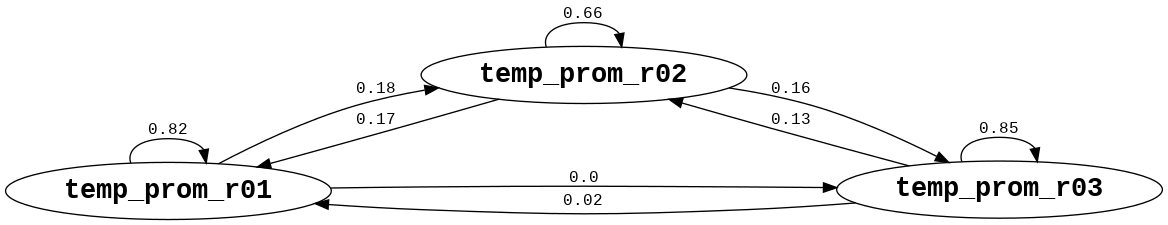

In [ ]:
#@title Establecer y entrenar modelo de Markov

# iniciliza listas auxiliares
obs_seq = x_train
sts_seq = y_train

# define modelo
if obs_seq is None:

  # Cadena de Markov
  modelMarkov = MarkovChain().from_data(sts_seq)
  print("> Cadena de Markov establecido.")

  # muestra información del modelo
  print("")
  print("> Tipos de Estados identificados: ", modelMarkov.states)

  obsMatrix = pd.DataFrame(modelMarkov.observed_p_matrix,
              index = modelMarkov.states,
              columns = modelMarkov.states)
  print( "\n> Matriz de Probabilidades de Observaciones: \n", obsMatrix )

else:
  #  Hidden Markov Model (HMM)
  modelMarkov = HiddenMarkovModel().from_seq(obs_seq, sts_seq)
  print("> Modelo Oculto de Markov (HMM) establecido.")

  # muestra información del modelo
  print("")
  print("> Tipos de Estados identificados: ", modelMarkov.states)
  print("> Tipos de Observaciones identificados: ", modelMarkov.observations)

  # priors probabilities
  piMatrix = pd.DataFrame(modelMarkov.pi,
              index = modelMarkov.states,
              columns = [ "" ])
  print( "\n> Matriz de Probabilidad Inicial: ", piMatrix )

  # transition probability matrix for all states
  tpMatrix = pd.DataFrame(modelMarkov.tp,
              index = modelMarkov.states,
              columns = modelMarkov.states)
  print( "\n> Matriz de Probabilidades de Transiciones: \n", tpMatrix )

  # Emission probability matrix for all states and observations.
  epMatrix = pd.DataFrame(modelMarkov.ep,
                      index = modelMarkov.states,
                      columns = modelMarkov.observations)
  print( "\n> Matriz de Probabilidad de Emisión: \n", epMatrix )

print( "\n> Diagrama: ")
if len(modelMarkov.states) >= 10:
  print("No se muestra el diagrama por tener gran cantidad de estados!")
else:
  generarGrafico(modelMarkov)


*** Resultados con datos de Entrenamiento: 
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r02 / M: temp_prom_r03 [ ERROR! ]
  R: temp_prom_r03 / M: temp_prom_r02 [ ERROR! ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R: temp_prom_r03 / M: temp_prom_r03 [ OK ]
  R

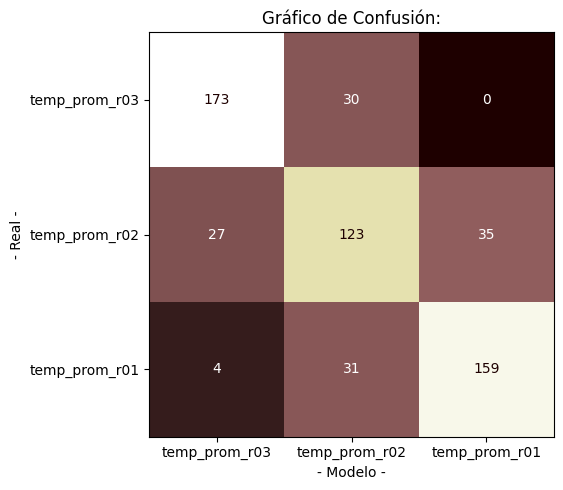

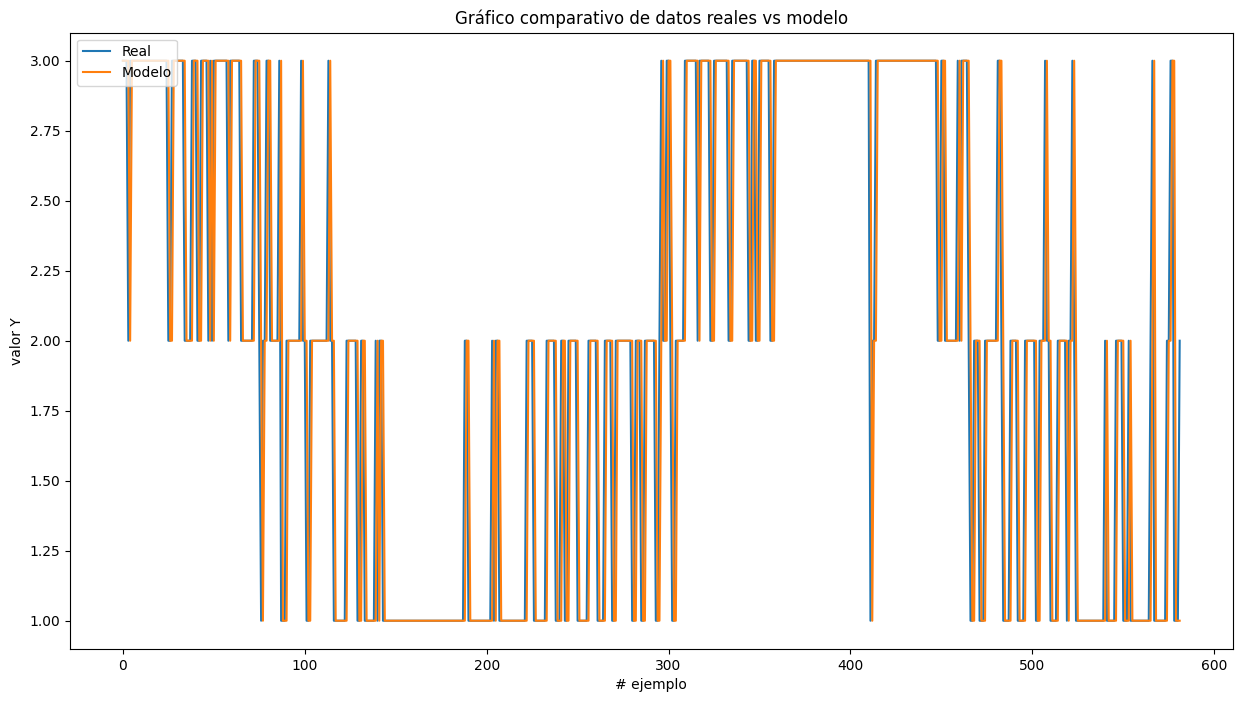

In [ ]:
#@title Evaluar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = True #@param {type:"boolean"}

def probarHMM(xData, yData, mostrarDetalle=False):

  # inicializa y prepara listas
  classReal = []
  classPreds = []
  clases_map = []

  if isinstance(modelMarkov, HiddenMarkovModel):
    esHMM = True
    nomModelo = "HMM"
    iniPrueba = 0
  else:
    esHMM = False
    nomModelo = "CM"
    iniPrueba = 1
  for i in range(iniPrueba, len(yData)-1):

      # utiliza el modelo para generar las predicciones
      if esHMM:
          # es HiddenMarkovModel
          yModelo, _ = modelMarkov.viterbi_new( [xData[i]] )
      else:
          # es CadenaMarkov
          # toma el primero como inicial
          clAnt = yData[i-1]
          _, yModelo = modelMarkov.simulate(1, start=clAnt)

      # determina clase predecida y real
      clPred = yModelo[0]
      clReal = yData[i]
      # registra para métricas
      classReal.append( clReal )
      classPreds.append( clPred )
      if clReal not in clases_map:
        clases_map.append( clReal )
      if clPred not in clases_map:
        clases_map.append( clPred )

      if mostrarDetalle:
        strTitulo = "  "
        if xData is not None:
          strTitulo = strTitulo + str(xData[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"
        print(strTitulo)

  # muestra reporte de clasificación
  print("\n Reporte de Clasificación: ")
  print(classification_report(classReal, classPreds, zero_division=0))

  # muestra matriz de confusion
  print('\nMatriz de Confusión ( real / ' + nomModelo + ' ): ')
  cm = confusion_matrix(classReal, classPreds, labels=clases_map)
  cmtx = pd.DataFrame(
      cm,
      index=['r:{:}'.format(x) for x in clases_map],
      columns=['m:{:}'.format(x) for x in clases_map]
    )
  # agrega para poder mostrar la matrix de confusión completa
  pd.options.display.max_rows = 100
  pd.options.display.max_columns = 100
  cmtx.sort_index(axis=0, inplace=True)
  cmtx.sort_index(axis=1, inplace=True)
  print(cmtx)
  print("\n")

  # gráfico de comparación
  dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clases_map)
  fig, ax = plt.subplots(figsize=(15,5))
  dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
  dispCM.ax_.set_title('Gráfico de Confusión:')
  dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
  plt.tight_layout()
  plt.show()
  print("")

  # muestra grafico
  graficarSerieDatos(datosReal=sacarDiscreatizacionDatos(classReal),
                     datosModelo=sacarDiscreatizacionDatos(classPreds),
                     titulo="Gráfico comparativo de datos reales vs modelo")

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarHMM(x_train, y_train, mostrar_detalle_entrenamiento)



*** Resultados con datos de Prueba: 
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r02 / M: temp_prom_r01 [ ERROR! ]
  R: temp_prom_r01 / M: temp_prom_r02 [ ERROR! ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r02 / M: temp_prom_r01 [ ERROR! ]
  R: temp_prom_r02 / M: temp_prom_r02 [ OK ]
  R: temp_prom_r02 / M: temp_prom_r02 [ OK ]
  R: temp_prom_r02 / M: temp_prom_r02 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r02 [ ERROR! ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]
  R: temp_prom_r01 / M: temp_prom_r01 [ OK ]


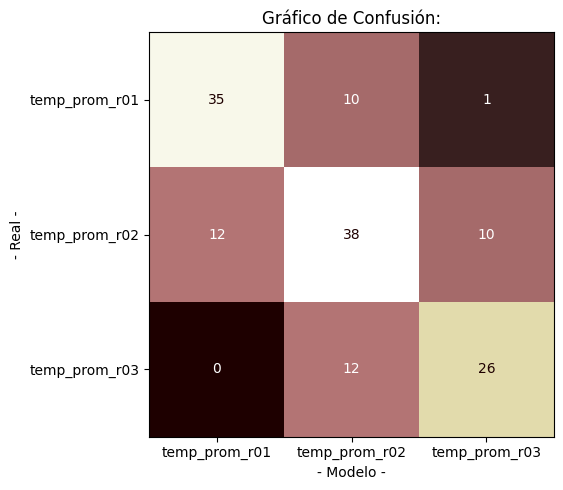

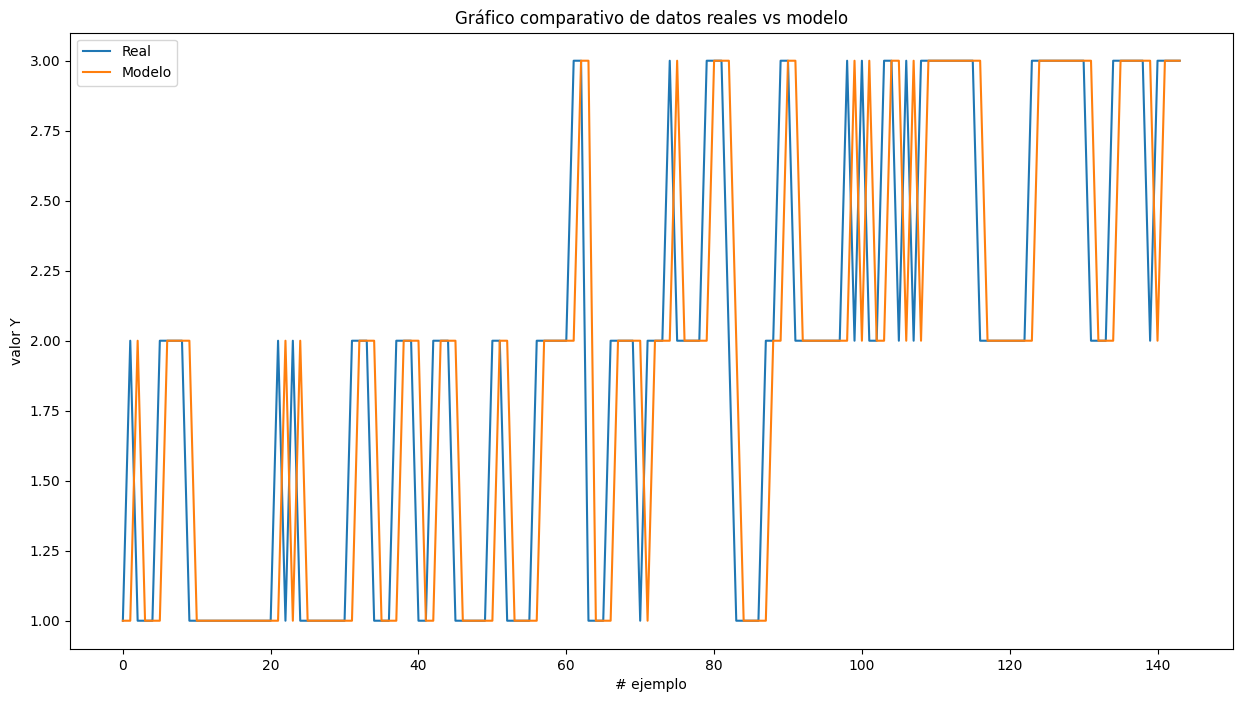

In [ ]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarHMM(x_test, y_test, mostrar_detalle_prueba)

In [ ]:
#@title Guardar Modelo

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov'  #@param {type:"string"}

if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/modelMarkov.joblib"
    joblib.dump(modelMarkov, fn_modelo)
    print("\n-Modelo Markov guardado en ", fn_modelo,"\n")

    fn_prepDatos = path_modelo + "/FUNC_PREP_DATOS_X.joblib"
    joblib.dump(prepararDatosModMarkov_X, fn_prepDatos)
    print("\n-Función para preparar datos de entrada guardada en ", fn_prepDatos,"\n")

    fn_prepDatos = path_modelo + "/CONFIG_PREP_DATOS_X.joblib"
    joblib.dump(
              {'att_entrada_tipo_discretizacion': att_entrada_tipo_discretizacion,
              'att_entrada_cant_rangos_discretizacion': att_entrada_cant_rangos_discretizacion,
              'atributo_entrada':atributo_entrada}
            , fn_prepDatos)
    print("\n-Configuración para preparar datos de entrada guardada en ", fn_prepDatos,"\n")


    fn_prepDatos = path_modelo + "/FUNC_PREP_DATOS_Y.joblib"
    joblib.dump(prepararDatosModMarkov_Y, fn_prepDatos)
    print("\n-Función para preparar datos de salida guardada en ", fn_prepDatos,"\n")

    fn_prepDatos = path_modelo + "/CONFIG_PREP_DATOS_Y.joblib"
    joblib.dump(
              {'att_clase_preparacion_discretizacion': att_clase_preparacion_discretizacion,
               'att_clase_tipo_discretizacion': att_clase_tipo_discretizacion,
               'att_clase_cant_rangos_discretizacion':att_clase_cant_rangos_discretizacion,
               'atributo_clase':atributo_clase,
               'nombre_clases':nombre_clases,
               'clases_map':clases_map}
            , fn_prepDatos)
    print("\n-Configuración para preparar datos de salida guardada en ", fn_prepDatos,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo Markov guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov/modelMarkov.joblib 


-Función para preparar datos de entrada guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov/FUNC_PREP_DATOS_X.joblib 


-Configuración para preparar datos de entrada guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov/CONFIG_PREP_DATOS_X.joblib 


-Función para preparar datos de salida guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov/FUNC_PREP_DATOS_Y.joblib 


-Configuración para preparar datos de salida guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosMarkov/CONFIG_PREP_DATOS_Y.joblib 

